# Demo: Accounting for mesophyll conductance in the photosynthesis module & calculating carbon-13 discrimination

## Imports

In [2]:
# setting path
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')

sys.path.append(pyAPES_main_folder)

# imports
import numpy as np
import matplotlib.pyplot as plt

# force iPython re-import modules at each call
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import xarray as xr
import seaborn as sns
sns.set_context('notebook')

In [4]:
from pyAPES.leaf.photo import photo_c3_medlyn_farquhar, photo_c3_medlyn_farquhar_gm
from pyAPES.leaf.boundarylayer import leaf_boundary_layer_conductance
from pyAPES.isotopes.carbon import carbon_discrimination

## Define plant parameters

In [5]:
pt1 = { 'name': 'pine',
        'LAImax': 2.1, # maximum annual LAI m2m-2
        # seasonal cycle of photosynthetic activity: pyAPES.planttype.phenology.Photo_cycle
        'phenop': {
            'Xo': 0.0, # initial delayed temperature [degC]
            'fmin': 0.1, # minimum relative photosynthetic capacity
            'Tbase': -4.7,  # base temperature [degC]
            'tau': 8.33,  # time constant [d]
            'smax': 18.0  # threshold for full acclimation [degC]
            },
        # seasonal cycle of LAI: #  pyAPES.planttype.phenology.LAI_cycle
        'laip': {
            'lai_min': 0.8, # minimum LAI, fraction of annual maximum [-]
            'lai_ini': None, # initial LAI, if None lai_ini = Lai_min * LAImax
            'DDsum0': 0.0, # initial degree-day sum [degC]
            'Tbase': 5.0, # base temperature for degree-day sy
            'ddo': 45.0, # degree-days at bud burst [days]
            'ddmat': 250.0, #degreedays at full maturation [days]
            'sdl': 12.0, # day length [h] for starting autumn senecence
            'sdur': 30.0 # duration [d] of senescence
            },
        # A-gs model: pyAPES.leaf.photo
        'photop': {
            'Vcmax': 55.0, # maximum carboxylation rate [umol m-2 (leaf) s-1] at 25 degC
            'Jmax': 105.0,  # maximum electron transport rate[umol m-2 (leaf) s-1] at 25 degC1.97*Vcmax (Kattge and Knorr, 2007)
            'Rd': 0.0, # dark respiration rate [umol m-2 (leaf) s-1] at 25 degC
            'tresp': { # temperature response (Kattge and Knorr, 2007)
                'Vcmax': [78., 200., 649.], # [activation energy [kJ mol-1], deactivation energy [kJ mol-1]
                                 #             entropy factor [kJ mol-1]]
                'Jmax': [56., 200., 646.],
                'Rd': [33.0],
                'gm': [100., 200., 700.,]
                },
            'alpha': 0.2,   # quantum efficiency parameter [-]
            'theta': 0.7,   # curvature parameter [-]
            'beta': 0.95,   # co-limitation parameter [-]
            'g1': 2.3,      # USO-model stomatal slope kPa^(0.5)
            'g0': 5.0e-3,   # residual conductance for CO2 [mol m-2 s-1]
            'kn': 0.5,      # nitrogen attenuation coefficient; affects Vcmax, Jmax, Rd profile in PlantType [-]
            'drp': [0.39, 0.83, 0.31, 3.0], # Rew-based drought response parameters.
            'gm': {
                'gm25': 0.2, # gm at 25C mol m-2 s-1
                'Ngradient': False,
                'parstress': False,
                'tempstress': False,
                'fmin': 0.15, #Knauer et al., 2019 GCB gm is always at least gm25*fmin
            },
            },
        'leafp': {
            'lt': 0.02,     # leaf length scale [m]
            },

        # root zone: pyAPES.planttype.rootzone.RootUptake
        'rootp': {
            'root_depth': 0.5, # rooting depth [m]
            'beta': 0.943, # root distribution shape parameter [-]
            'root_to_leaf_ratio': 2.0, # fine-root to leaf-area ratio [-]
            'root_radius': 2.0e-3, # [m]
            'root_conductance': 5.0e8, # [s]
            }
        }

## Select input data

In [6]:
input = xr.open_dataset('../data/Demos/data_demo_A_gs.nc')

In [7]:
input = input.sel(stand=0)

## Example 1: How accounting for gm changes the estimated assimilation rate, CO<sub>2</sub> concentration inside and outside leaves, stomatal conductance and transpiration rate

In [8]:
_, gb_c, gb_v = leaf_boundary_layer_conductance(input.canopy_wind_speed.data, pt1['leafp']['lt'], input.canopy_temperature.data, 0.0, input.canopy_pressure.data)

In [9]:
An_no_gm, Rd_no_gm, fe_no_gm, gs_no_gm, ci_no_gm, cs_no_gm = photo_c3_medlyn_farquhar(pt1['photop'], input.canopy_leaf_incident_par.data, input.canopy_temperature.data, input.canopy_VPD.data, input.canopy_co2.data, gb_c, gb_v, input.canopy_pressure.data)

In [10]:
An_gm, Rd_gm, fe_gm, gs_gm, ci_gm, cs_gm, gm_gm, cc_gm = photo_c3_medlyn_farquhar_gm(pt1['photop'], input.canopy_leaf_incident_par.data, input.canopy_leaf_incident_par.data*0.1, input.canopy_temperature.data, input.canopy_VPD.data, input.canopy_co2.data, gb_c, gb_v, input.canopy_pressure.data)

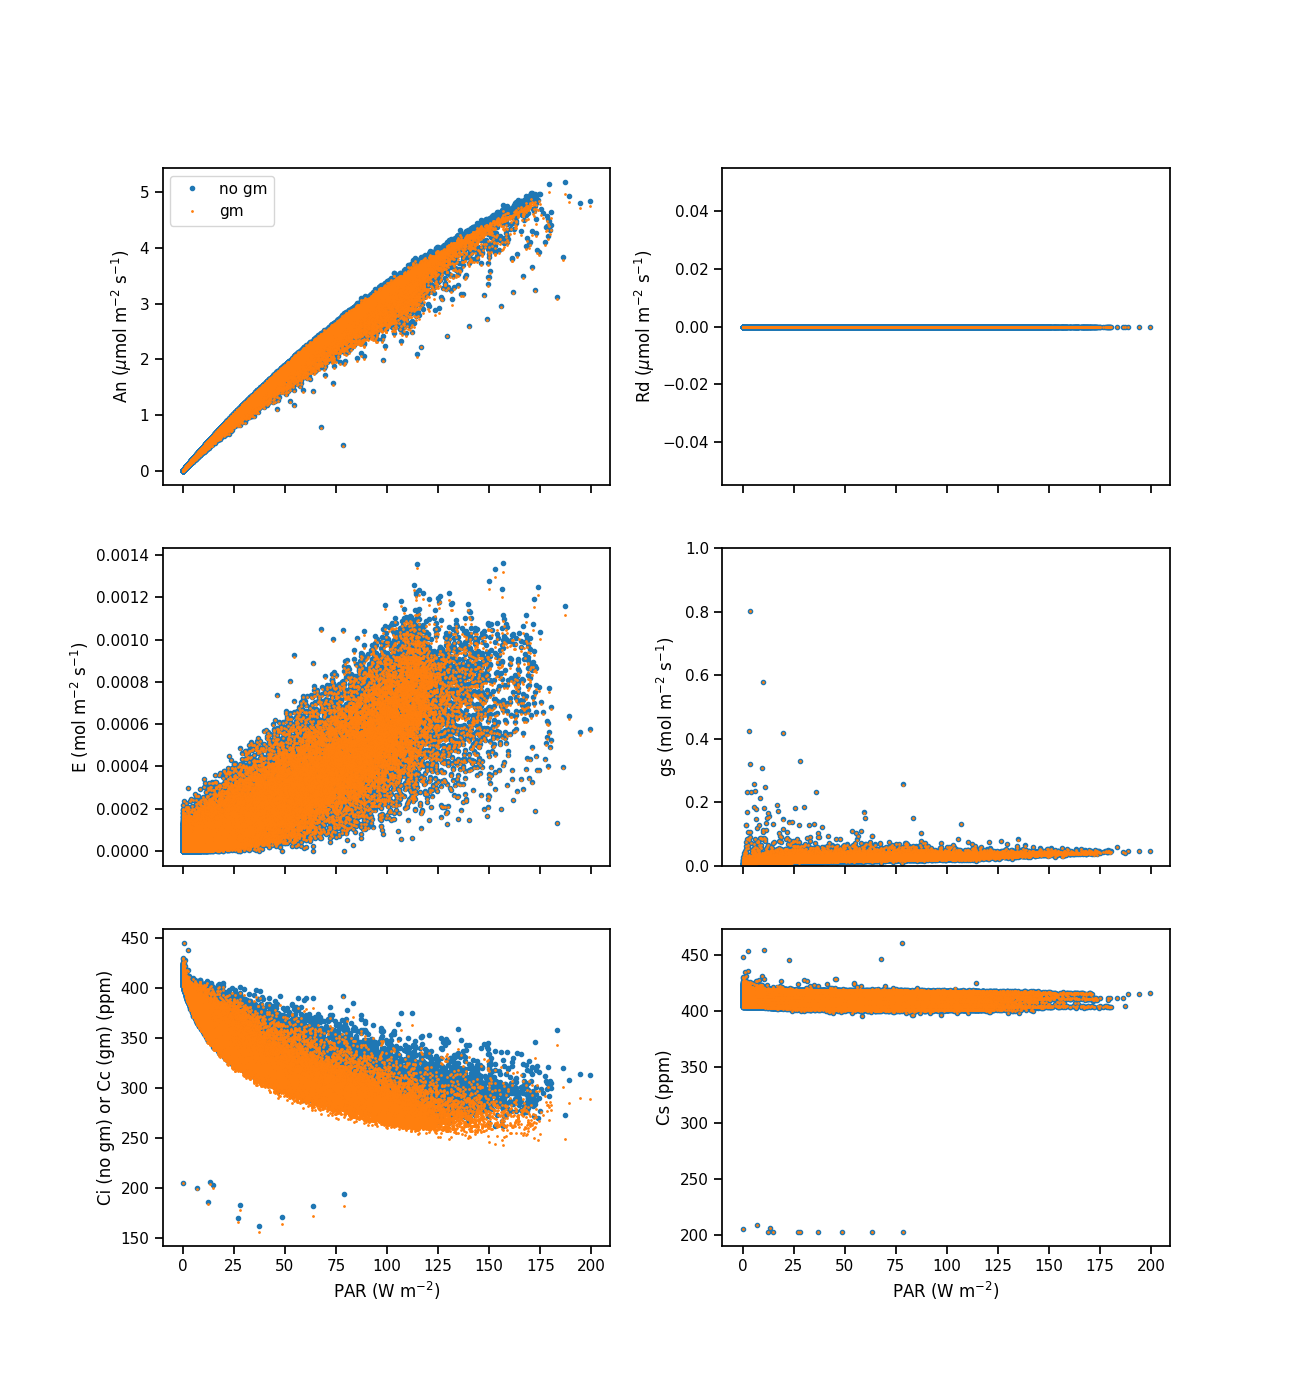

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13, 14), sharex=True)
fig.subplots_adjust(wspace=0.25)
axs = axs.flatten()

plot_vals = [[An_no_gm, An_gm], [Rd_no_gm, Rd_gm], [fe_no_gm, fe_gm],
             [gs_no_gm, gs_gm], [ci_no_gm, cc_gm], [cs_no_gm, cs_gm]]
ylabels = ['An ($\mu$mol m$^{-2}$ s$^{-1}$)', 'Rd ($\mu$mol m$^{-2}$ s$^{-1}$)', 'E (mol m$^{-2}$ s$^{-1}$)','gs (mol m$^{-2}$ s$^{-1}$)', 'Ci (no gm) or Cc (gm) (ppm)', 'Cs (ppm)']
for i, vals in enumerate(plot_vals):
    axs[i].plot(input.canopy_leaf_incident_par.data, vals[0],
                marker='.', linestyle='', label='no gm')
    axs[i].plot(input.canopy_leaf_incident_par.data, vals[1],
                marker='.', markersize=2, linestyle='',  label='gm')
    
    axs[i].set_ylabel(ylabels[i])
    if i == 0:
        axs[0].legend()
    if i >3:
        axs[i].set_xlabel('PAR (W m$^{-2}$)')

    if i==3:
        axs[i].set_ylim([0,1])

## Estimate the differences in the same parameters with numerical metrics

In [12]:
plot_vals = [[An_no_gm, An_gm], [Rd_no_gm, Rd_gm], [fe_no_gm, fe_gm],
             [gs_no_gm, gs_gm], [ci_no_gm, cc_gm], [cs_no_gm, cs_gm]]
labels = ['An', 'Rd', 'E','gs', 'Ci', 'Cs']
print('2-norm')
for i, vals in enumerate(plot_vals):
    print(f'{labels[i]}: {np.round(np.sqrt(np.sum((vals[0]-vals[1])**2)),10)}')

print('Median Absolute difference')
for i, vals in enumerate(plot_vals):
    print(f'{labels[i]}: {np.round(np.median(np.abs(vals[0]-vals[1])),10)}')

2-norm
An: 5.8829514807
Rd: 0.0
E: 0.0010047396
gs: 1551.3456600058
Ci: 1688.1806175642
Cs: 2.5462744809
Median Absolute difference
An: 0.0078216573
Rd: 0.0
E: 7.051e-07
gs: 8.1089e-05
Ci: 7.0685612487
Cs: 0.0035924192


# Example 2: Define low and high PAR input for demonstrating how environmental parameters affect 13C-discrimination

The high PAR data is the same input data set as above and the low PAR dataset is calculated from the high PAR dataset by scaling down PAR, VPD and air temperature

In [13]:
input_high_par = input.copy()
input_low_par = input.copy()

input_low_par['canopy_leaf_incident_par'] = 0.5*input_low_par['canopy_leaf_incident_par']
input_low_par['canopy_VPD'] = 0.5*input_low_par['canopy_VPD']
input_low_par['canopy_temperature'] = 0.75*input_low_par['canopy_temperature']

In [14]:
_, gb_c, gb_v = leaf_boundary_layer_conductance(input_high_par.canopy_wind_speed.data, pt1['leafp']['lt'], input_high_par.canopy_temperature.data, 0.0, input_high_par.canopy_pressure.data)
An_high_par, Rd_high_par, fe_high_par, gs_high_par, ci_high_par, cs_high_par, gm_high_par, cc_high_par = photo_c3_medlyn_farquhar_gm(pt1['photop'], input_high_par.canopy_leaf_incident_par.data, input_high_par.canopy_leaf_incident_par.data*0.1, input_high_par.canopy_temperature.data, input_high_par.canopy_VPD.data, input_high_par.canopy_co2.data, gb_c, gb_v, input_high_par.canopy_pressure.data)

In [15]:
_, gb_c, gb_v = leaf_boundary_layer_conductance(input_low_par.canopy_wind_speed.data, pt1['leafp']['lt'], input_low_par.canopy_temperature.data, 0.0, input_low_par.canopy_pressure.data)
An_low_par, Rd_low_par, fe_low_par, gs_low_par, ci_low_par, cs_low_par, gm_low_par, cc_low_par = photo_c3_medlyn_farquhar_gm(pt1['photop'], input_low_par.canopy_leaf_incident_par.data, input_low_par.canopy_leaf_incident_par.data*0.1, input_low_par.canopy_temperature.data, input_low_par.canopy_VPD.data, input_low_par.canopy_co2.data, gb_c, gb_v, input_low_par.canopy_pressure.data)

## Calculate carbon-13 discrimination $\Delta^{13}\mathrm{C}$
carbon_discrimation function calcualtes 13C discrimination by photosynthesis based on 3 alternative models of increasing complexity. None of the models take into account post-photosynthetic fractionation processes.
```
def carbon_discrimination(leaf_gas_exchange, forcing,
                          a_b=2.9 ,a_s=4.4, a_m=1.8, b_simple=27.,
                          b_classical=29., f=8., e=-6., gm=0.1):
leaf_gas_exchange (dict):
    'net_co2': net CO2 flux (umol m-2 leaf s-1)
    'dark_respiration': CO2 respiration (umol m-2 leaf s-1)
    'leaf_temperature': leaf temperature (degC)
    'leaf_internal_co2': leaf internal CO2 mixing ratio (umol/mol)
    'leaf_surface_co2': leaf surface CO2 mixing ratio (umol/mol)
    'leaf_chloropast_co2': leaf chloroplast CO2 mixing ratio (umol/mol)
forcing (dict):
    'co2': ambient CO2 mixing ratio (umol/mol)

Returns:
    leaf_13C_discrimination (dict):
        'D13C_simple': (permil)
        'D13C_classical': (permil)
        'D13C_classical_gm': (permil)
```

In [16]:
D13C_data = {'net_co2': An_high_par, 'dark_respiration': Rd_high_par, 'leaf_temperature': input_high_par['canopy_temperature'].data, 'leaf_internal_co2': ci_high_par, 'leaf_surface_co2': cs_high_par, 'leaf_chloroplast_co2': cc_high_par}
environmental_data = {'co2': input_high_par['canopy_co2'].data}

res_high_par = carbon_discrimination(D13C_data, environmental_data, gm = gm_high_par)

In [17]:
D13C_data = {'net_co2': An_low_par, 'dark_respiration': Rd_low_par, 'leaf_temperature': input_low_par['canopy_temperature'].data, 'leaf_internal_co2': ci_low_par, 'leaf_surface_co2': cs_low_par, 'leaf_chloroplast_co2': cc_low_par}
environmental_data = {'co2': input_low_par['canopy_co2'].data}

res_low_par = carbon_discrimination(D13C_data, environmental_data, gm = gm_low_par)

## Plot daily mean $\Delta^{13}\mathrm{C}$ and how much they differ between low and high par conditions

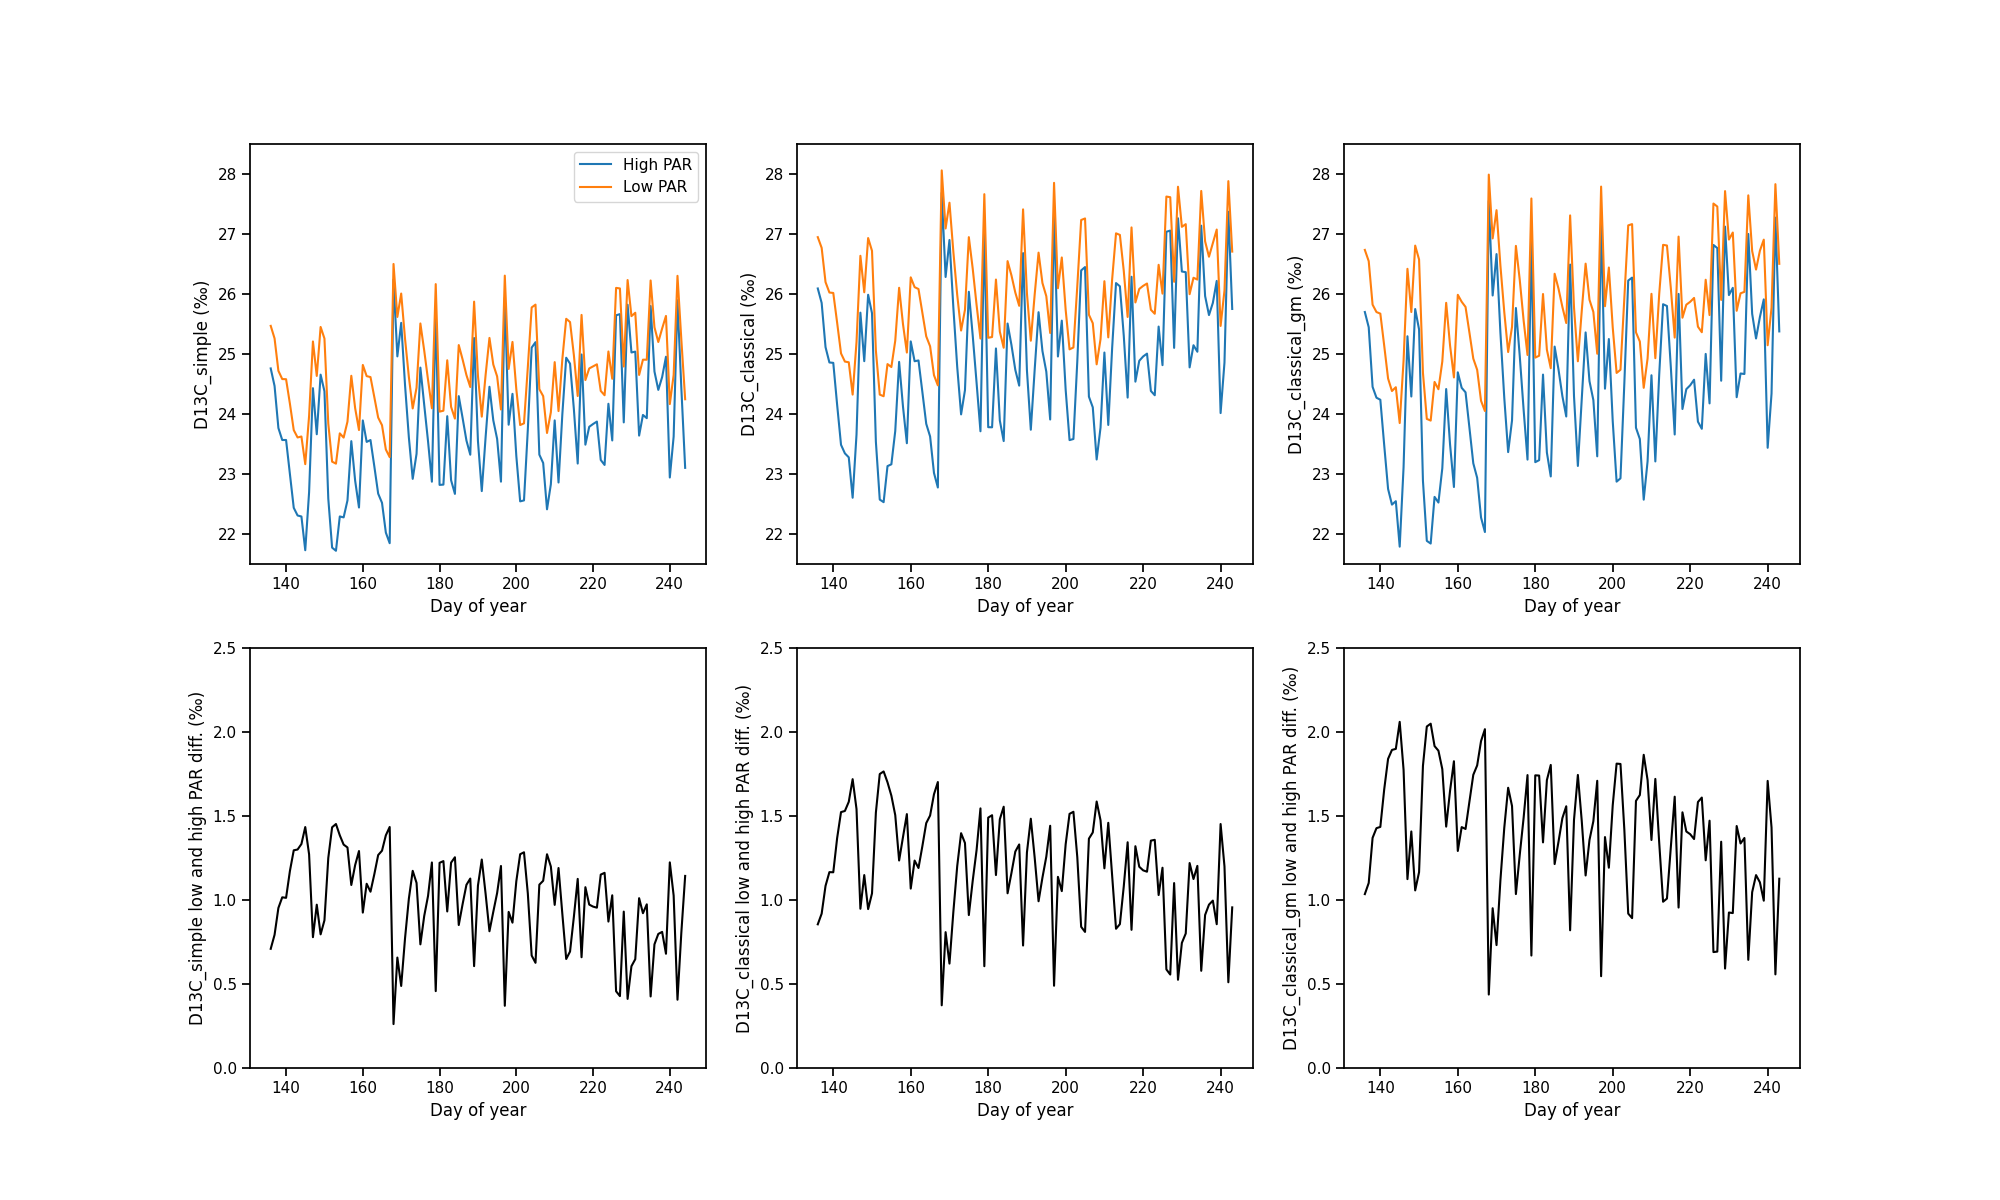

In [18]:
fig, axs = plt.subplots(figsize=(20,12), nrows=2, ncols=3)
axs = axs.flatten()
models = list(res_high_par.keys())

for i,ax in enumerate(axs[:-3]):
    doy_mask = input_high_par.date.dt.dayofyear.data 
    plot_vals_high_par = [np.mean(i) for i in np.split(res_high_par[models[i]], np.unique(doy_mask,return_index=True)[1][2:])]
    plot_vals_low_par = [np.mean(i) for i in np.split(res_low_par[models[i]], np.unique(doy_mask,return_index=True)[1][2:])]
    dat_high_par = res_high_par[models[i]].data 
    ax.plot(np.unique(doy_mask)[1:], plot_vals_high_par, label='High PAR')
    ax.plot(np.unique(doy_mask)[1:], plot_vals_low_par, label='Low PAR')
    ax.set_ylabel(f'{models[i]} (‰)')
    ax.set_xlabel('Day of year')
    ax.set_ylim([21.5, 28.5])
    if i==0:
        ax.legend(loc='best')

for i,ax in enumerate(axs[-3:]):
    doy_mask = input_high_par.date.dt.dayofyear.data 
    plot_vals_high_par = [np.mean(i) for i in np.split(res_high_par[models[i]], np.unique(doy_mask,return_index=True)[1][2:])]
    plot_vals_low_par = [np.mean(i) for i in np.split(res_low_par[models[i]], np.unique(doy_mask,return_index=True)[1][2:])]
    dat_high_par = res_high_par[models[i]].data 
    ax.plot(np.unique(doy_mask)[1:], np.array(plot_vals_low_par) - np.array(plot_vals_high_par), color='k')
    ax.set_ylabel(f'{models[i]} low and high PAR diff. (‰)')
    ax.set_xlabel('Day of year')
    ax.set_ylim([0, 2.5])